In [ ]:
!pip install timm
!pip install torchdata
import timm
import torch 
from PIL import Image
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
import torchdata as td
import os
from sklearn import metrics
import numpy as np
import sys
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#adjust path
sys.path += ['/content/gdrive/My Drive/BE224B']

**Load Train/Test Data**

In [ ]:
#adjust path to train and test folders
train_root ='/content/gdrive/My Drive/BE224B/NeedleImages/train/'
test_root ='/content/gdrive/My Drive/BE224B/NeedleImages/test/'

#initialize transformers
transformers = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.CenterCrop(512)])

train_data = ImageFolder(root = train_root, transform = transformers)

test_data = ImageFolder(root = test_root, transform = transformers)

#get class weights
class_weights = []
for root, subdir, files in os.walk(train_root):
  if len(files) > 0: 
    class_weights.append(1/len(files))
print(class_weights)

sample_weights = [0] * len(train_data)

#set sample weights
for idx, (data, label) in enumerate(train_data):
  class_weight = class_weights[label] 
  sample_weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

#initialize dataloaders
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size = 4, drop_last = False, sampler = sampler)

test_data_loader = torch.utils.data.DataLoader(test_data, batch_size = 4, shuffle = True, drop_last = False)

**Load Model**

In [ ]:
path = '/content/gdrive/My Drive/BE224B/model.pth'

In [ ]:
# model = timm.create_model('resnet50d', num_classes = 2, in_chans = 1, pretrained = False, global_pool = 'max')
# 
# model.load_state_dict(torch.load(path)["params"])
# run_dict = torch.load(path)

**Instantiate Model**

In [ ]:
run_dict = {}
run_dict["epoch"] = 0
model = timm.create_model('resnet50d', num_classes = 2, in_chans = 1, pretrained = False, global_pool = 'max')

**Loss Function & Optimizer**

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

**Testing Function**

In [ ]:
def testing(model):
  model.eval()
  y = []
  y_hat = []
  for i, data in enumerate(test_data_loader):
      inputs, labels = data
      y.extend(labels.tolist())
      outputs = model(inputs)
      predicted_y = torch.argmax(outputs, 1)
      y_hat.extend(predicted_y.tolist())

  print(run_dict["epoch"])
  print(y_hat)
  print(y)
  print('Overall Metrics: ', metrics.classification_report(y, y_hat, zero_division = 0))
  print('Jaccard Score: ', metrics.jaccard_score(y, y_hat, zero_division = 0))
  print('Confusion Matrix: ', metrics.confusion_matrix(y, y_hat, labels = [0, 1]))
  conf_matrix = metrics.confusion_matrix(y, y_hat, labels = [0, 1])
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

**Training**

In [ ]:
model.train()
for epoch in range((run_dict['epoch']+1), 151):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%10 == 0:
            print(f'[{epoch}, {i+1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
    run_dict["params"] = model.state_dict()
    print("epoch: ", epoch)
    run_dict["epoch"] = epoch
    torch.save(run_dict, path)
    print('Model Saved')

    if epoch%10 == 0:
      testing(model)

run_dict["params"] = model.state_dict()
torch.save(run_dict, path)

print('Model Saved')
print('Finished Training')

**Saving Model**

In [ ]:
# path = '/content/gdrive/My Drive/BE224B/model.pth'
# torch.save(run_dict, path)

**Testing**

111
[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0

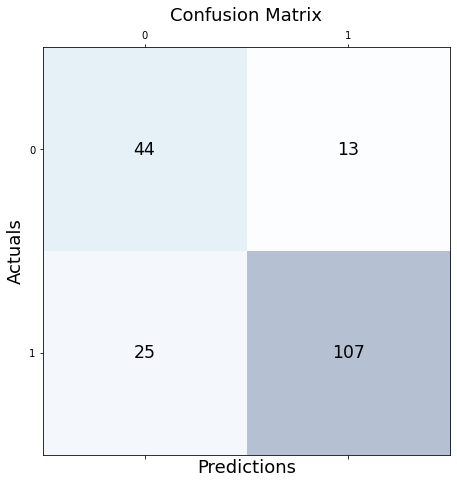

In [ ]:
testing(model)

**Move data into class subfolders**

In [ ]:
# import shutil
# import os
# labels = pd.read_csv('/Users/Emily/Documents/BioE 224B/NeedleImages/Labels.csv')
# labels.drop('ID', inplace = True, axis = 1)
# print(labels)

# root = '/Users/Emily/Documents/BioE 224B/NeedleImages/'
# move = '/Users/Emily/Documents/BioE 224B/'

# for filename, class_name in labels.values:
# #     if not os.path.exists(root + str(class_name)):
# #         os.mkdir(root + str(class_name))
#     print(filename, class_name)
#     shutil.copy(os.path.join(root,filename), os.path.join(move,class_name))